In [1]:
%load_ext autoreload
%autoreload 2

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

/tmp/ipykernel_53264/3467240019.py:4: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
import pandas as pd
from tqdm import tqdm

In [3]:
import matplotlib.pyplot as plt

/beegfs/desy/user/buhmae/conda/envs/torch_113/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import numpy as np
import torch.utils.data
from torch import optim
import h5py

from models.shower_flow import compile_HybridTanH_model

device = torch.device('cuda:0')

In [5]:
model, distribution = compile_HybridTanH_model(num_blocks=10, 
                                           num_inputs=65, ### when 'condioning' on additional Esum, Nhits etc add them on as inputs rather than 
                                           num_cond_inputs=1, device=device)  # num_cond_inputs

In [6]:
default_params = {
    "batch_size" : 2048,
    "epochs" : 1000,
    "shuffle" : True,
}

In [7]:
kwargs = {}
params = {}
for param in default_params.keys():

    if param in kwargs.keys():
        params[param] = kwargs[param]
    else:
        params[param] = default_params[param]

In [8]:
path = 'BEEGFS/data/calo-clouds/hdf5/high_granular_grid/train/10-90GeV_x36_grid_regular_524k_float32.hdf5'
energy = h5py.File(path, 'r')['energy'][:]
events = h5py.File(path, 'r')['events'][:]

num_points = (events[:][:, -1] > 0).sum(axis=1)
visible_energy = (events[:][:, -1]).sum(axis=1)

In [10]:
outdir = 'BEEGFS/6_PointCloudDiffusion/dataset/tmp/'

# save 
# np.save(outdir+'clusters_per_layer.npy', clusters_per_layer)
# np.save(outdir+'e_per_layer.npy', e_per_layer)

# load
clusters_per_layer = np.load(outdir+'clusters_per_layer.npy')
e_per_layer = np.load(outdir+'e_per_layer.npy')

In [11]:
# normalize cluster and energy per layer to [0,1]
clusters_per_layer = clusters_per_layer / clusters_per_layer.max(axis=1).reshape(len(clusters_per_layer), 1)
e_per_layer = e_per_layer / e_per_layer.max(axis=1).reshape(len(e_per_layer), 1)

In [13]:
# center of gravity 

def get_cog(x,y,z,e):
    return np.sum((x * e), axis=1) / e.sum(axis=1), np.sum((y * e), axis=1) / e.sum(axis=1), np.sum((z * e), axis=1) / e.sum(axis=1)

cog = get_cog(
    events[:, 0],
    events[:, 1],
    events[:, 2],
    events[:, 3],
)


In [15]:
# clusters_per_layer = clusters_per_layer / 400

df = pd.DataFrame([])
df['energy'] = energy[:].reshape(-1)   # normalisation done in training loop

df['num_points'] = num_points / 5000
df['visible_energy'] = visible_energy / 2.5 

df['cog_x'] = cog[0] / 25
df['cog_y'] = (cog[1] - 15) / 15
df['cog_z'] = (cog[2] - 40) / 20

df['clusters_per_layer'] = clusters_per_layer.tolist()
df['e_per_layer'] = e_per_layer.tolist()

In [16]:
dataset = torch.utils.data.TensorDataset(
    torch.tensor(df.energy.values), 
    torch.tensor(df.num_points.values), 
    torch.tensor(df.visible_energy.values),
    torch.tensor(df.cog_x.values),
    torch.tensor(df.cog_y.values),
    torch.tensor(df.cog_z.values),
    torch.tensor(df.clusters_per_layer),
    torch.tensor(df.e_per_layer),
    )

In [17]:
train_loader = torch.utils.data.DataLoader(dataset, batch_size=params["batch_size"], shuffle=params["shuffle"], pin_memory=True)


In [18]:
batch = next(iter(train_loader))

In [19]:
for item in batch:
    print(item.shape)

torch.Size([2048])
torch.Size([2048])
torch.Size([2048])
torch.Size([2048])
torch.Size([2048])
torch.Size([2048])
torch.Size([2048, 30])
torch.Size([2048, 30])


In [20]:
output_path = 'BEEGFS/6_PointCloudDiffusion/shower_flow/'
prefix = '220714_cog_e_layer_'
outpath = output_path + prefix

In [21]:
# torch.manual_seed(123)

lr = 1e-5   # default: 5e-5
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

model.load_state_dict(torch.load(outpath+f'ShowerFlow_best.pth')['model'])

# load best_loss
with open(outpath+f'ShowerFlow_best_loss.txt', 'r') as f:
    best_loss = float(f.read())

In [23]:
epoch_start = 284   # default = 1

In [38]:
model.train()

losses = []
for epoch in range(epoch_start, params["epochs"]+1):
    input_list = []
    loss_list = []
#     for batch_idx, (mu, logvar, e, theta, e_sum) in enumerate(train_loader):
    for batch_idx, (energy, num_points, visible_energy, cog_x, cog_y, cog_z, clusters_per_layer, e_per_layer) in enumerate(tqdm(train_loader)):

        E_true = energy.view(-1, 1).to(device).float()
        num_points = num_points.view(-1, 1).to(device).float()
        energy_sum = visible_energy.view(-1,1).to(device).float()
        cog_x = cog_x.view(-1, 1).to(device).float()
        cog_y = cog_y.view(-1, 1).to(device).float()
        cog_z = cog_z.view(-1, 1).to(device).float()
        clusters_per_layer = clusters_per_layer.to(device).float()
        e_per_layer = e_per_layer.to(device).float()
   
        # normalise conditional labels
        E_true = (E_true/100).float()

        input_data = torch.cat((num_points, energy_sum, cog_x, cog_y, cog_z, clusters_per_layer, e_per_layer), 1)   #### input data structure required for network with additional features in latent space (e.g. Esum)
        

        optimizer.zero_grad()

        # try to add context for conditioning by concatenating 
        context = E_true
        
        if np.any(np.isnan(input_data.clone().detach().cpu().numpy())) == True:
            print('Nans in the training data!')
            
        #### check if any of the weights are nans
        if torch.stack([torch.isnan(p).any() for p in model.parameters()]).any():
            print('Weights are nan!')
            # load recent model
            model.load_state_dict(torch.load(outpath+f'ShowerFlow_latest.pth')['model'])
            optimizer = optim.Adam(model.parameters(), lr=lr)
            print(f'latest model reloaded, optimizer resetted')
                           
        nll = -distribution.condition(context).log_prob(input_data)
        loss = nll.mean()
        loss.backward()

        optimizer.step() 

        distribution.clear_cache()
        
        loss_list.append(loss.item())

    print(epoch, np.mean(loss_list))
    losses.append(np.mean(loss_list))
    if epoch == 1:
        best_loss = np.mean(loss_list)

    if torch.stack([torch.isnan(p).any() for p in model.parameters()]).any(): # save models only if no nan weights
        print('model not saved due to nan weights')
    else:
        torch.save(
            {'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),},
            outpath+f'ShowerFlow_latest.pth'
        )

        if epoch%10 == 0:
            torch.save(
                {'model': model.state_dict(),
                'optimizer': optimizer.state_dict(),},
                outpath+f'ShowerFlow_{epoch}.pth'
            )

        # save best model based on loss
        if np.mean(loss_list) <= best_loss:
            best_loss = np.mean(loss_list)
            torch.save(
                {'model': model.state_dict(),
                'optimizer': optimizer.state_dict(),},
                outpath+f'ShowerFlow_best.pth'
            )
            # save best loss value to txt file
            with open(outpath+f'ShowerFlow_best_loss.txt', 'w') as f:
                f.write(str(best_loss))
            print('best model saved, with loss: ', best_loss)
        # print('model saved')
        



SyntaxError: invalid syntax (3974420783.py, line 18)

In [22]:
# load best checkpoint
model.load_state_dict(torch.load(outpath+f'ShowerFlow_best.pth')['model'])
optimizer.load_state_dict(torch.load(outpath+f'ShowerFlow_best.pth')['optimizer'])

model.eval()
print('model loaded')

model loaded


In [23]:
# generate 
torch.manual_seed(123)

E_true_list = []
samples_list = []
num_points_list = []
visible_energy_list = []
cog_x_list = []
cog_y_list = []
cog_z_list = []
clusters_per_layer_list = []
e_per_layer_list = []
for batch_idx, (energy, num_points, visible_energy, cog_x, cog_y, cog_z, clusters_per_layer, e_per_layer) in enumerate(tqdm(train_loader)):
    E_true = energy.view(-1, 1).to(device).float()
    E_true = (E_true/100).float()
    with torch.no_grad():
        samples = distribution.condition(E_true).sample(torch.Size([E_true.shape[0], ])).cpu().numpy()
    E_true_list.append(E_true.cpu().numpy())
    samples_list.append(samples)
    num_points_list.append(num_points.cpu().numpy())
    visible_energy_list.append(visible_energy.cpu().numpy())
    cog_x_list.append(cog_x.cpu().numpy())  
    cog_y_list.append(cog_y.cpu().numpy())
    cog_z_list.append(cog_z.cpu().numpy())
    clusters_per_layer_list.append(clusters_per_layer.cpu().numpy())
    e_per_layer_list.append(e_per_layer.cpu().numpy())

E_true = np.concatenate(E_true_list, axis=0)
samples = np.concatenate(samples_list, axis=0)
num_points = np.concatenate(num_points_list, axis=0)
visible_energy = np.concatenate(visible_energy_list, axis=0)
cog_x = np.concatenate(cog_x_list, axis=0)
cog_y = np.concatenate(cog_y_list, axis=0)
cog_z = np.concatenate(cog_z_list, axis=0)
clusters_per_layer = np.concatenate(clusters_per_layer_list, axis=0)
e_per_layer = np.concatenate(e_per_layer_list, axis=0)

100%|██████████| 257/257 [00:23<00:00, 10.88it/s]


In [24]:
samples.shape, E_true.shape

((524959, 65), (524959, 1))

In [26]:
# sampled 
num_points_sampled = samples[:, 0] * 5000
visible_energy_sampled = samples[:, 1] * 2.5
cog_x_sampled = samples[:, 2] * 25
cog_y_sampled = samples[:, 3] * 15 + 15
cog_z_sampled = samples[:, 4] * 20 + 40
clusters_per_layer_sampled = samples[:, 5:35]
e_per_layer_sampled = samples[:, 35:]

# truth
E_true = E_true * 100
num_points = num_points * 5000
visible_energy = visible_energy * 2.5
cog_x = cog_x * 25
cog_y = cog_y * 15 + 15
cog_z = cog_z * 20 + 40


# clip cluster and energies per layer to [0,1]
clusters_per_layer_sampled = np.clip(clusters_per_layer_sampled, 0, 1)
e_per_layer_sampled = np.clip(e_per_layer_sampled, 0, 1)

In [27]:
print(cog_x.min(), cog_x.max())
print(cog_y.min() - 15, cog_y.max() - 15)
print(cog_z.min() - 40 , cog_z.max() - 40)

-48.901173 25.97003
-6.486481666564941 13.383855819702148
-19.979446411132812 20.289112091064453


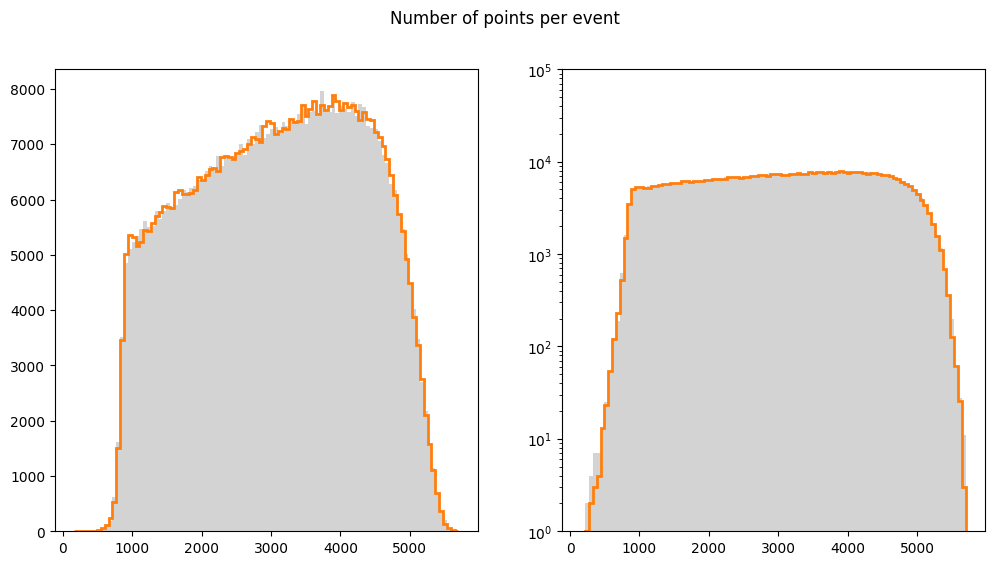

In [28]:
fig = plt.figure(figsize=(12,6))
gs = gridspec.GridSpec(1,2)

ax = fig.add_subplot(gs[0])
h = plt.hist(num_points.flatten(), bins=100, color='lightgrey')
h2 = plt.hist(num_points_sampled.flatten(), bins=h[1], histtype='step', lw=2, color='tab:orange')

# same but in log scale
ax = fig.add_subplot(gs[1])
h = plt.hist(num_points.flatten(), bins=100, color='lightgrey')
h2 = plt.hist(num_points_sampled.flatten(), bins=h[1], histtype='step', lw=2, color='tab:orange')
plt.yscale('log')
plt.ylim(1, 1e5)

plt.suptitle('Number of points per event')
plt.show()

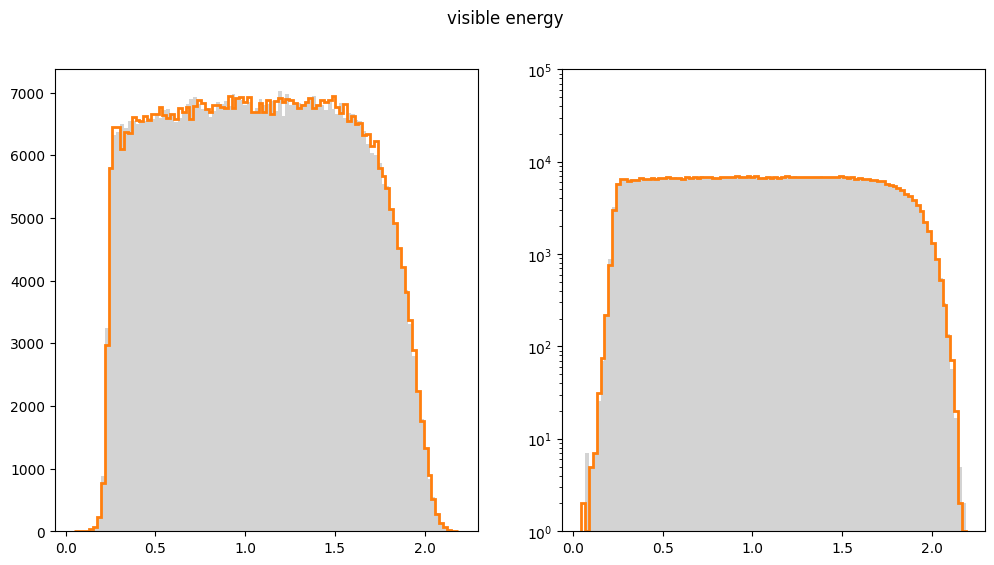

In [29]:
fig = plt.figure(figsize=(12,6))
gs = gridspec.GridSpec(1,2)

ax = fig.add_subplot(gs[0])
h = plt.hist(visible_energy.flatten(), bins=100, color='lightgrey')
h2 = plt.hist(visible_energy_sampled.flatten(), bins=h[1], histtype='step', lw=2, color='tab:orange')

# same but in log scale
ax = fig.add_subplot(gs[1])
h = plt.hist(visible_energy.flatten(), bins=100, color='lightgrey')
h2 = plt.hist(visible_energy_sampled.flatten(), bins=h[1], histtype='step', lw=2, color='tab:orange')
plt.yscale('log')
plt.ylim(1, 1e5)

plt.suptitle('visible energy')
plt.show()

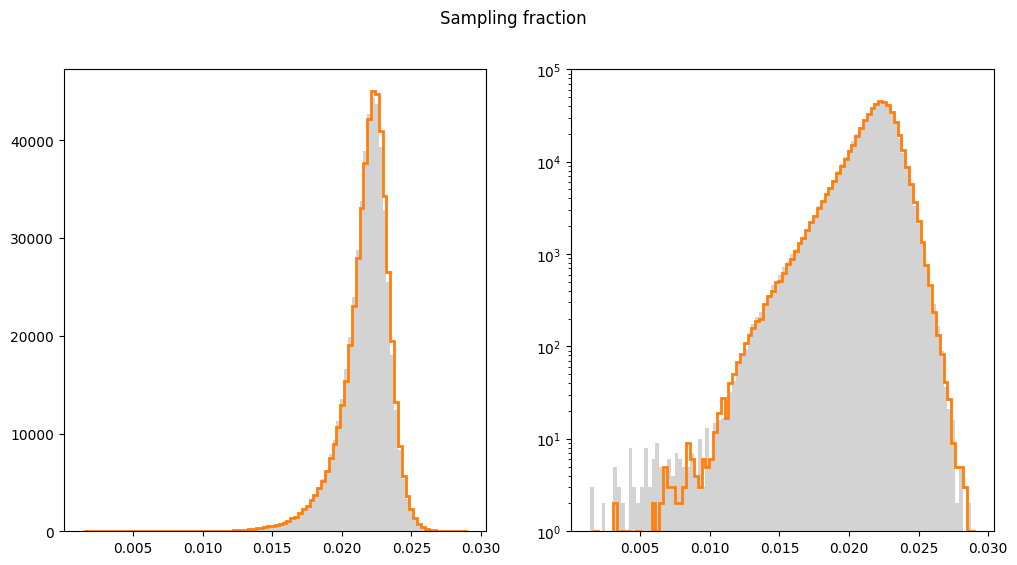

In [30]:
# sampling fraction
fig = plt.figure(figsize=(12,6))
gs = gridspec.GridSpec(1,2)

ax = fig.add_subplot(gs[0])
h = plt.hist(visible_energy.flatten()/E_true.flatten(), bins=100, color='lightgrey')
h2 = plt.hist(visible_energy_sampled.flatten()/E_true.flatten(), bins=h[1], histtype='step', lw=2, color='tab:orange')

# same but in log scale
ax = fig.add_subplot(gs[1])
h = plt.hist(visible_energy.flatten()/E_true.flatten(), bins=100, color='lightgrey')
h2 = plt.hist(visible_energy_sampled.flatten()/E_true.flatten(), bins=h[1], histtype='step', lw=2, color='tab:orange')
plt.yscale('log')
plt.ylim(1, 1e5)

# title over all subplots
fig.suptitle('Sampling fraction')
plt.show()

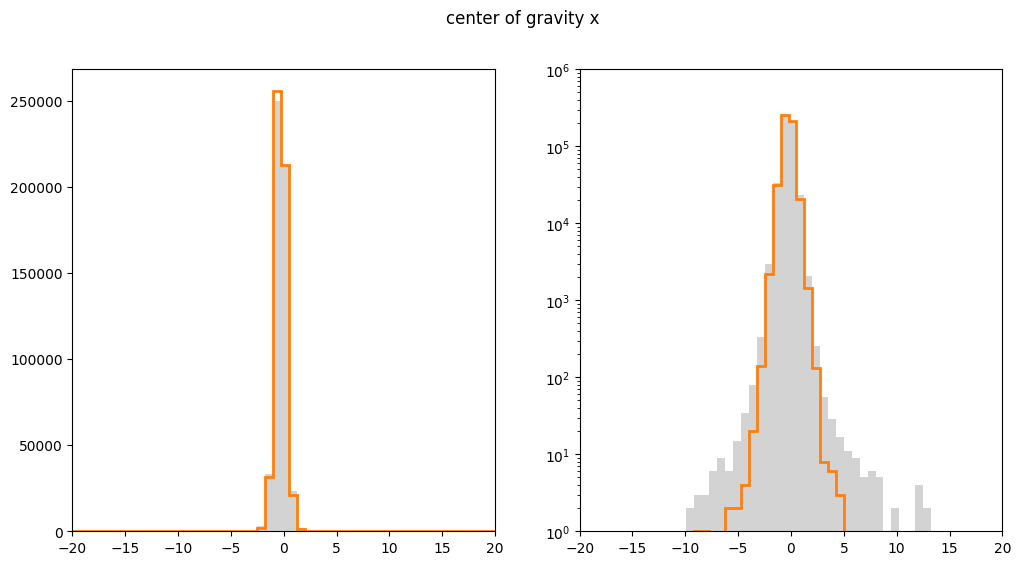

In [31]:
fig = plt.figure(figsize=(12,6))
gs = gridspec.GridSpec(1,2)

ax = fig.add_subplot(gs[0])
h = plt.hist(cog_x.flatten(), bins=100, color='lightgrey')
h2 = plt.hist(cog_x_sampled.flatten(), bins=h[1], histtype='step', lw=2, color='tab:orange')
plt.xlim(-20,20)

# same but in log scale
ax = fig.add_subplot(gs[1])
h = plt.hist(cog_x.flatten(), bins=100, color='lightgrey')
h2 = plt.hist(cog_x_sampled.flatten(), bins=h[1], histtype='step', lw=2, color='tab:orange')
plt.yscale('log')
plt.ylim(1, 1e6)
plt.xlim(-20,20)

plt.suptitle('center of gravity x')
plt.show()

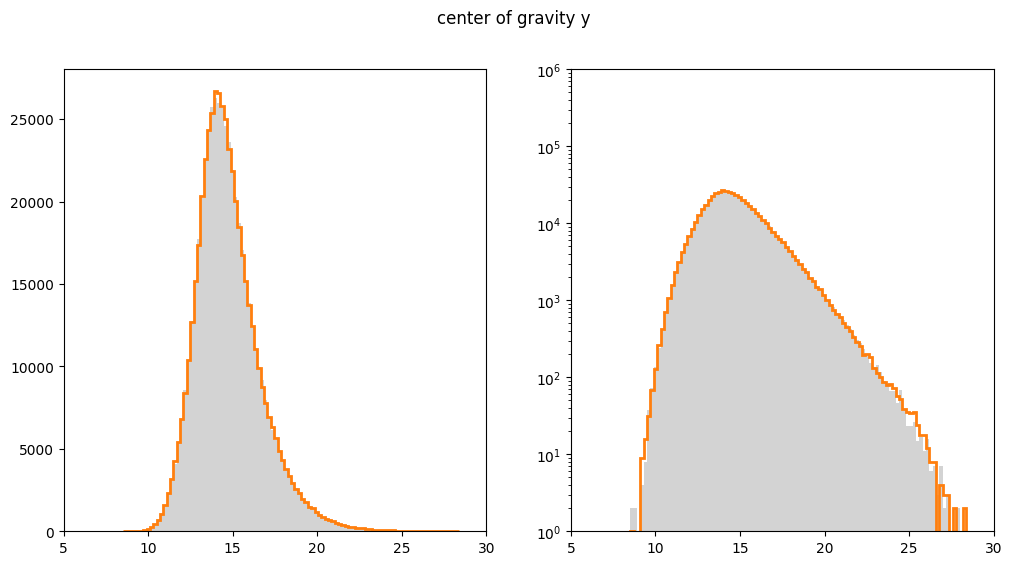

In [32]:
fig = plt.figure(figsize=(12,6))
gs = gridspec.GridSpec(1,2)

ax = fig.add_subplot(gs[0])
h = plt.hist(cog_y.flatten(), bins=100, color='lightgrey')
h2 = plt.hist(cog_y_sampled.flatten(), bins=h[1], histtype='step', lw=2, color='tab:orange')
plt.xlim(5,30)

# same but in log scale
ax = fig.add_subplot(gs[1])
h = plt.hist(cog_y.flatten(), bins=100, color='lightgrey')
h2 = plt.hist(cog_y_sampled.flatten(), bins=h[1], histtype='step', lw=2, color='tab:orange')
plt.yscale('log')
plt.ylim(1, 1e6)
plt.xlim(5,30)

plt.suptitle('center of gravity y')
plt.show()

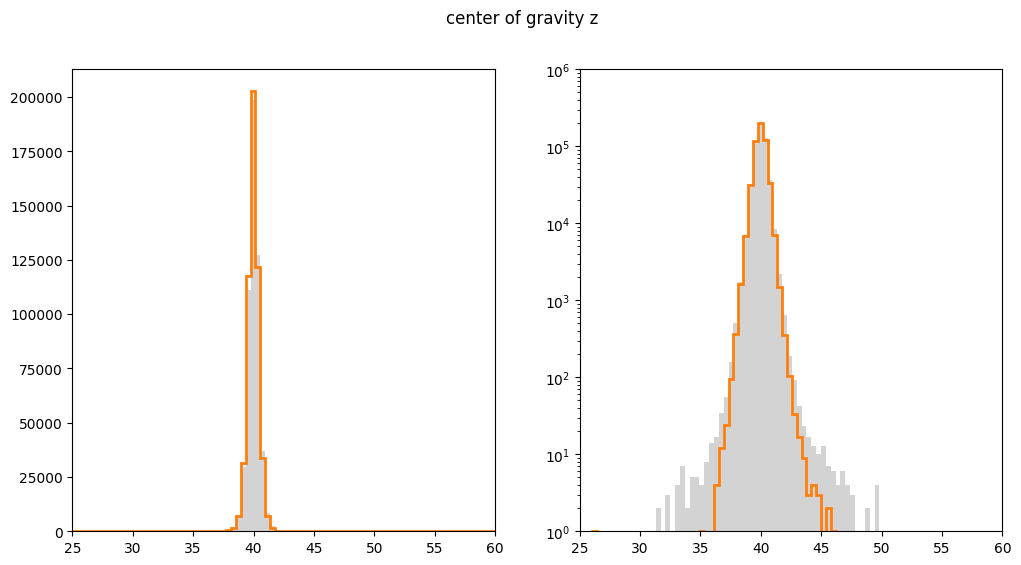

In [33]:
fig = plt.figure(figsize=(12,6))
gs = gridspec.GridSpec(1,2)

ax = fig.add_subplot(gs[0])
h = plt.hist(cog_z.flatten(), bins=100, color='lightgrey')
h2 = plt.hist(cog_z_sampled.flatten(), bins=h[1], histtype='step', lw=2, color='tab:orange')
plt.xlim(25,60)

# same but in log scale
ax = fig.add_subplot(gs[1])
h = plt.hist(cog_z.flatten(), bins=100, color='lightgrey')
h2 = plt.hist(cog_z_sampled.flatten(), bins=h[1], histtype='step', lw=2, color='tab:orange')
plt.yscale('log')
plt.ylim(1, 1e6)
plt.xlim(25,60)

plt.suptitle('center of gravity z')
plt.show()

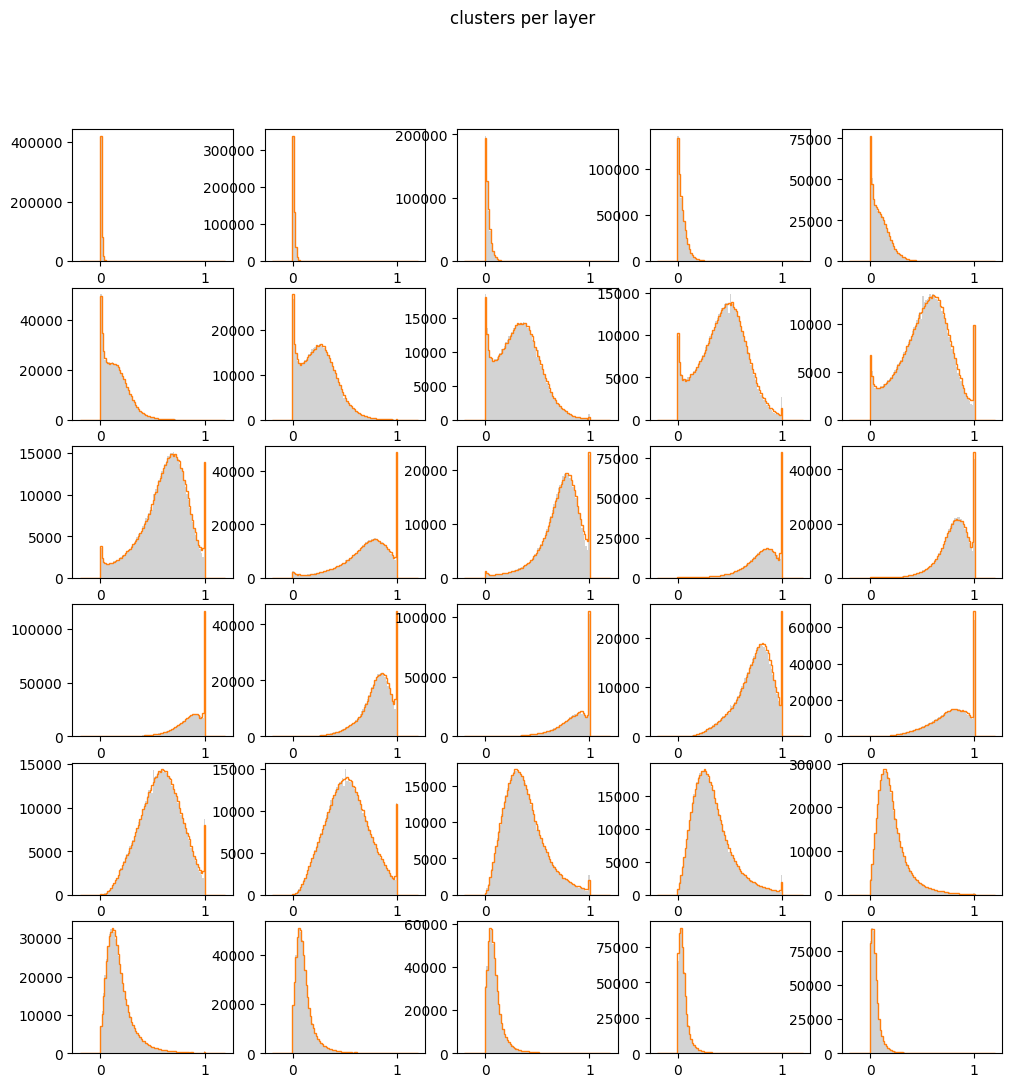

In [34]:
fig = plt.figure(figsize=(12,12))
gs = gridspec.GridSpec(6,5)

for i in range(30):
    fig.add_subplot(gs[i])
    h = plt.hist(clusters_per_layer[:,i].flatten(), bins=100, color='lightgrey', range=[-0.2,1.2])
    h2 = plt.hist(clusters_per_layer_sampled[:,i].flatten(), bins=h[1], histtype='step', lw=1, color='tab:orange')

plt.suptitle('clusters per layer')
plt.show()

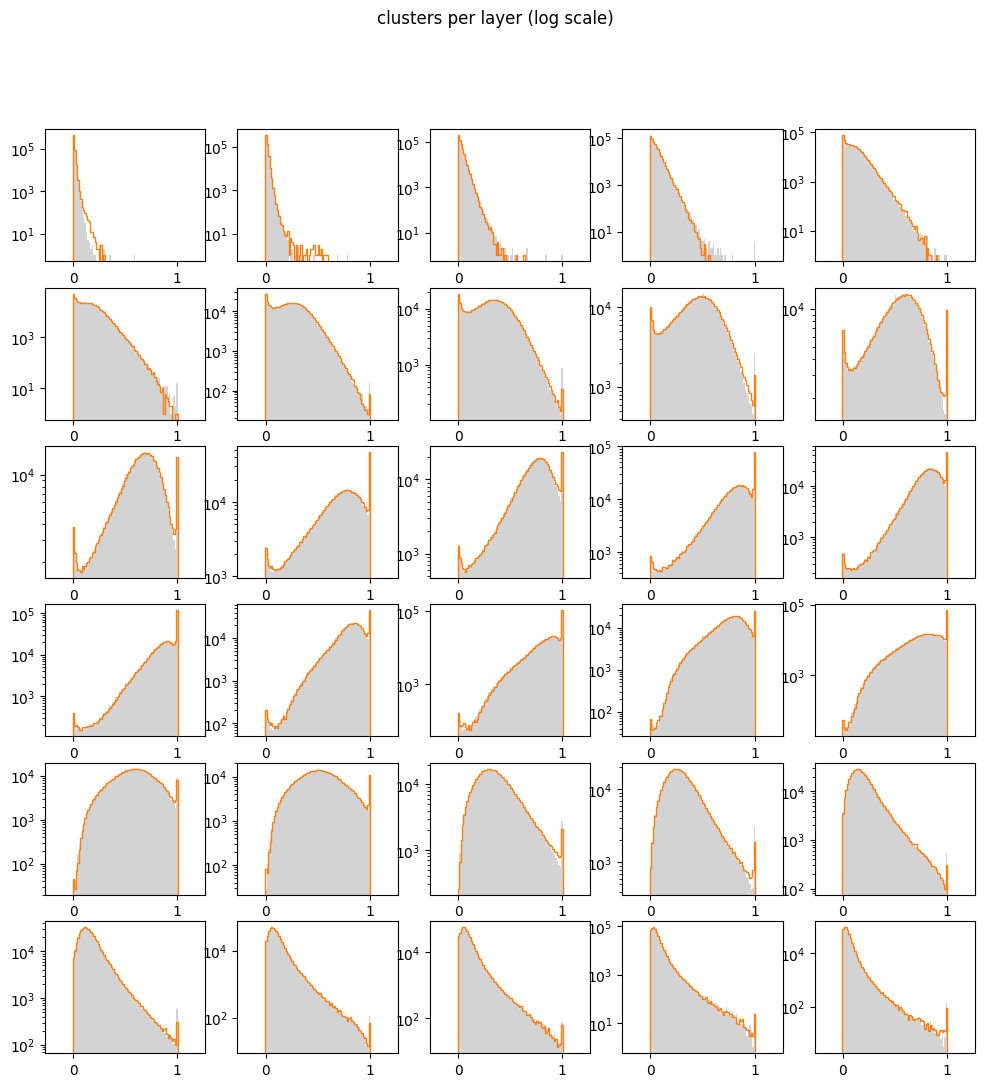

In [35]:
fig = plt.figure(figsize=(12,12))
gs = gridspec.GridSpec(6,5)

for i in range(30):
    fig.add_subplot(gs[i])
    h = plt.hist(clusters_per_layer[:,i].flatten(), bins=100, color='lightgrey', range=[-0.2,1.2])
    h2 = plt.hist(clusters_per_layer_sampled[:,i].flatten(), bins=h[1], histtype='step', lw=1, color='tab:orange')
    plt.yscale('log')

plt.suptitle('clusters per layer (log scale)')
plt.show()

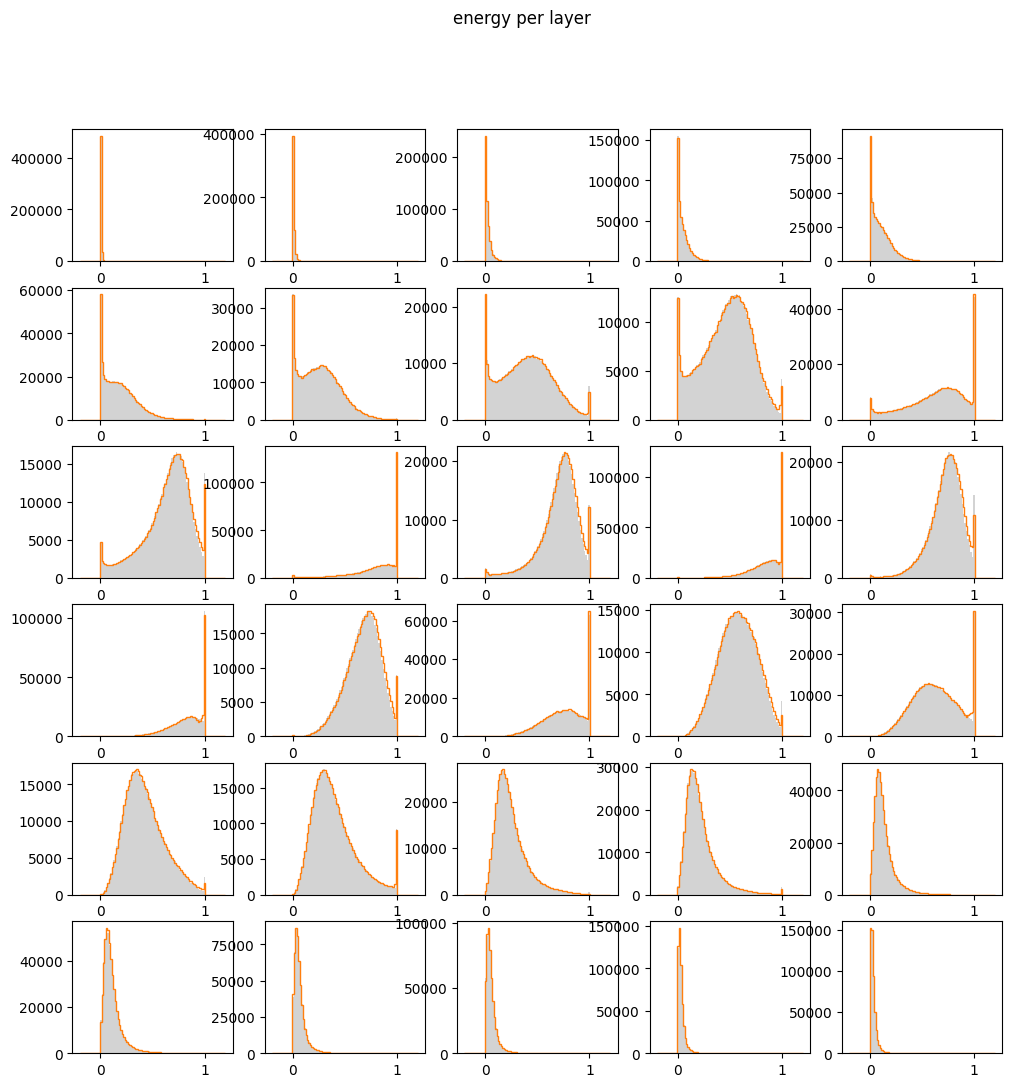

In [36]:
fig = plt.figure(figsize=(12,12))
gs = gridspec.GridSpec(6,5)

for i in range(30):
    fig.add_subplot(gs[i])
    h = plt.hist(e_per_layer[:,i].flatten(), bins=100, color='lightgrey', range=[-0.2,1.2])
    h2 = plt.hist(e_per_layer_sampled[:,i].flatten(), bins=h[1], histtype='step', lw=1, color='tab:orange')
    # plt.yscale('log')

plt.suptitle('energy per layer')
plt.show()

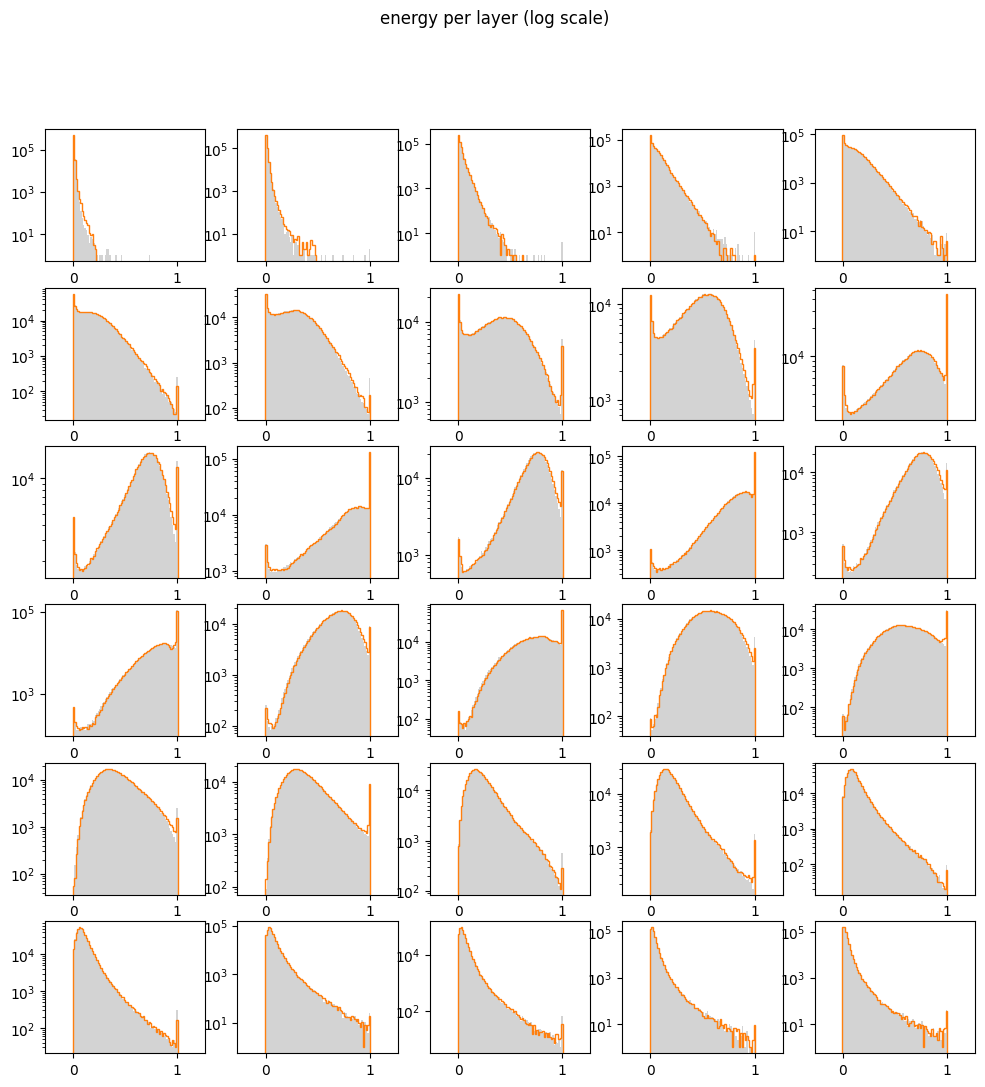

In [37]:
fig = plt.figure(figsize=(12,12))
gs = gridspec.GridSpec(6,5)

for i in range(30):
    fig.add_subplot(gs[i])
    h = plt.hist(e_per_layer[:,i].flatten(), bins=100, color='lightgrey', range=[-0.2,1.2])
    h2 = plt.hist(e_per_layer_sampled[:,i].flatten(), bins=h[1], histtype='step', lw=1, color='tab:orange')
    plt.yscale('log')

plt.suptitle('energy per layer (log scale)')
plt.show()